# Trophic model for gut
## Consumer-Resource model (CRM) with Trophic levels
The human gut microal community is complex because of 3 reason: (1) many microbial species (~570); (2) many metabolites involoved (~244); and (3) many microbe-metabolite interactions/links (>4400). Of all types of microbe-metabolite interactions/links, the cross-feeding makes the system more complicated to interpret. Previously, a literature-curated interspecies network of the human gut microbiota, called [NJS16](https://www.nature.com/articles/ncomms15393) is reported. This is an extensive data resource composed of ∼570 microbial species and 3 human cell types metabolically interacting through >4,400 small-molecule transport and macromolecule degradation events.

Here, we devoted to build a Consumer-Resource model (CRM) with trophic levels posted in the paper "[a evidence for a multi-level trophic organization of the human gut microbiome](https://www.biorxiv.org/content/10.1101/603365v1.full-text)". The model is devoted to study the complex microbe-metabolite network in human guts.

In concise, in the mode, a trophic level is considered as one round of carbon processing and is composed of two process: resource allocation to microbes and the following resource/byproduct generation by microbes. The simulation is stopped after several trophic levels because the residence time of resource in the human gut is assumed to be finite.

Previously, the code for the model is written in Matlab. Here a Python version of the model is proposed, providing further convenience for Machine Learning model to learn uptake rates and byproduct generation rates of all microbial species to different metabolites.

In [1]:
########### Self-customized setting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import sklearn
import math
from numba import jit, float64

#%% Plot Tong's default setting
SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.linewidth'] = 3

In [2]:
########### import the pickled file containing all processed data which are useful for simulations (the processing is
########### done in "Trophic_model_for_gut_data_processing.ipynb")
import pickle
pickle_in = open("Chia_network.pickle","rb")
net, i_selfish, i_intake, names = pickle.load(pickle_in)

pickle_in = open("Thai_data.pickle","rb")
thai_metagenome_ID, thai_metagenome, thai_metabolome_ID, thai_metabolome = pickle.load(pickle_in)

## Create maps of microbes and metabolites to their reduced matrix forms

In [3]:
#i_nonzero_microbes = net['microbes_ID'].unique()
#i_nonzero_microbes = np.sort(i_nonzero_microbes)
i_nonzero_microbes = thai_metagenome_ID.values.copy()
i_nonzero_metabolites = net['metabolites_ID'].unique()
i_nonzero_metabolites = np.sort(i_nonzero_metabolites)


df_metabolites = pd.DataFrame.from_dict({'oldID': i_nonzero_metabolites, 'newID':list(range(len(i_nonzero_metabolites)))})
df_metabolites.set_index('oldID', inplace=True)
df_microbes = pd.DataFrame.from_dict({'oldID': i_nonzero_microbes, 'newID':list(range(len(i_nonzero_microbes)))})
df_microbes.set_index('oldID', inplace=True)


outgoingNodes = df_metabolites.loc[net['metabolites_ID'].values].values.flatten()
ingoingNodesTemp = df_microbes.loc[net['microbes_ID'].values].values.flatten()
edge_types = net.iloc[~np.isnan(ingoingNodesTemp),2].values
outgoingNodes = outgoingNodes[~np.isnan(ingoingNodesTemp)]
ingoingNodes = ingoingNodesTemp[~np.isnan(ingoingNodesTemp)].astype(int)

net_reduced = pd.DataFrame.from_dict({'metabolites': outgoingNodes, 'microbes':ingoingNodes, 'edgeType':edge_types})
net = net_reduced.copy()

thai_metagenome_ID_reduced = df_microbes.loc[thai_metagenome_ID].values.flatten()
thai_metagenome_ID = thai_metagenome_ID_reduced[~np.isnan(thai_metagenome_ID_reduced)].astype(int)

thai_metabolome_ID_reduced = df_metabolites.loc[thai_metabolome_ID].values.flatten()
thai_metabolome_ID = thai_metabolome_ID_reduced[~np.isnan(thai_metabolome_ID_reduced)].astype(int)


i_selfish_reduced = df_microbes.loc[i_selfish].values.flatten()
i_selfish = i_selfish_reduced[~np.isnan(i_selfish_reduced)].astype(int)

i_intake_reduced = df_metabolites.loc[i_intake].values.flatten()
i_intake = i_intake_reduced[~np.isnan(i_intake_reduced)].astype(int)

/Users/tongwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  from ipykernel import kernelapp as app
/Users/tongwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


## Run the simulation with reduced matrix forms for one individual

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.4350254292045665
            Iterations: 10
            Function evaluations: 227
            Gradient evaluations: 10
     fun: 2.4350254292045665
     jac: array([ 0.        , -0.00853819,  0.07028782,  0.00888675,  0.5158169 ,
        0.00695616,  0.5158169 , -0.00318575,  0.23650047, -0.00714117,
        0.23884735,  0.1009917 ,  0.07105842, -0.00713146, -0.00863993,
        0.09273681,  0.5424481 ,  0.61806461, -0.01410729, -0.00784275])
 message: 'Optimization terminated successfully.'
    nfev: 227
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([5.00000000e-02, 1.18522175e+00, 6.05657813e-15, 5.55845978e-02,
       5.76567800e-15, 7.84340336e-01, 5.83405308e-15, 1.46314133e-02,
       4.17078655e-15, 1.16066460e+00, 5.15701444e-15, 6.37199005e-15,
       5.19076232e-15, 1.15865506e+00, 1.17948029e+00, 5.46294989e-15,
       6.60426658e-15, 5.89703126e-15, 1.27764841

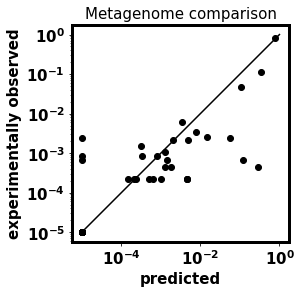

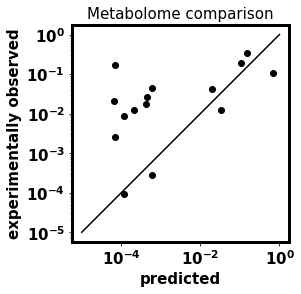

In [4]:
################################# Predict metabolome from individual's metagenome.
from numpy import array
from scipy.sparse import csr_matrix
import numpy.matlib
from scipy.optimize import minimize, rosen, rosen_der
from scipy.stats import pearsonr

MAX_ID_microbes = len(i_nonzero_microbes)  # MAX_ID_microbes is the maximum of ID labels for microbes.
MAX_ID_metabolites = len(i_nonzero_metabolites)  # MAX_ID_metabolites is the maximum of ID labels for metabolites.

def Ain_out(b_real, net):
    '''
    Ain_out is a function used to create sparse matrices made of metabolites and microbes 
    where metabolite consumption and production is considered. The matrices created are "m2b" and "b2m":
    (1) m2b is a matrix determines the nutrient splitting among microbes, and
    (2) b2m is a matrix determines the byproducts generation.
    Both matrices have rows representing bacterial species and columns representing metablolites.
    Two matrices are created based on (1) the metabolite consumption and production network which is 
    encode in "net" as a dataframe, and (2) the experimentally measured bacterial abundance "b_real".
    '''
    valid_index = np.where((net.iloc[:,2]==2) | (net.iloc[:,2]==5))[0]
    row = net.iloc[valid_index,0]
    col = net.iloc[valid_index,1]
    data = np.ones((len(valid_index),))
    m2b = csr_matrix( (data,(row,col)), shape=(MAX_ID_metabolites, MAX_ID_microbes)).toarray()#.todense()

    valid_index = np.where((net.iloc[:,2]==3) | (net.iloc[:,2]==5))[0]
    row = net.iloc[valid_index,0]
    col = net.iloc[valid_index,1]
    data = np.ones((len(valid_index),))
    b2m = csr_matrix( (data,(row,col)), shape=(MAX_ID_metabolites, MAX_ID_microbes)).toarray()#.todense()

    ########## Normalize the b2m by out_degree
    out_degree = b2m.sum(0).copy()
    out_degree[out_degree==0]=100
    b2m = (b2m / out_degree)

    ########## Normalize the m2b by proportion of microbial abundance in each individual
    b_real_repmat = numpy.matlib.repmat(b_real[np.newaxis,:], MAX_ID_metabolites, 1)
    m2b = m2b * b_real_repmat
    in_degree = m2b.sum(1)
    in_degree[in_degree==0]=100
    m2b = m2b / numpy.matlib.repmat(in_degree[:,np.newaxis], 1, MAX_ID_microbes)
    m2b = np.float32(m2b)
    b2m = np.float32(b2m)
    return [m2b, b2m]

def m2b_multiple_levels(f, m2b, b2m, numLevels_max):
    '''
    m2b_multiple_levels is a function used to generate matrices involving the calculation of metabolite 
    byproducts and microbial biomass after several trophic levels/layers. Those matrices are:
    (1) m2m_layer is a conversion matrix from the nutrient intake to the metabolite byproducts at a trophic
    level or layer.
    (2) m2m_total is a conversion matrix from the nutrient intake to a summation of metabolite byproducts at
    all trophic levels or layers.
    (3) m2b_total is a conversion matrix from the nutrient intake to a summation of all microbial/bacterial 
    biomass gain at all trophic levels or layers.
    Those matrices are computed based on (1) metabolite consumption matrix "m2b", (2) metabolite byproduct
    generation matrix "b2m", (3) byproduct/leakage fraction "f", and (4) number of trophic levels/layers in the 
    simulation "numLevels_max".
    '''
    m2m_layer = np.zeros((MAX_ID_metabolites, MAX_ID_metabolites, numLevels_max));  
    #m2b_total = np.zeros((MAX_ID_metabolites, MAX_ID_microbes));  
    m2b_total = np.zeros((MAX_ID_metabolites, MAX_ID_metabolites));  
    
    f_mul = numpy.matlib.repmat(f, 1, MAX_ID_metabolites)
    #s_step =  np.dot(b2m, m2b.T) # s_step is the conversion matrix of each trophic level/layer
    s_step =  np.dot(b2m, f_mul*m2b.T) # s_step is the conversion matrix of each trophic level/layer
    s_step_ii = np.eye(MAX_ID_metabolites, MAX_ID_metabolites);
    #f_mul = numpy.matlib.repmat(f[np.newaxis,:], MAX_ID, 1)#numpy.matlib.repmat(f, 1, MAX_ID)
    #f_mul = numpy.matlib.repmat(f, 1, MAX_ID_metabolites)
    
    for ii in range(numLevels_max):
        # m2b_total is a series made of s_step of each layer
        #m2b_total = m2b_total + f_mul**(ii) * s_step_ii
        #m2m_layer[:,:,ii] = f_mul**(ii) * s_step_ii
        m2b_total = m2b_total + s_step_ii
        m2m_layer[:,:,ii] = s_step_ii
        s_step_ii = np.dot(s_step_ii, s_step);  
    m2m_total = m2b_total;
    m2b_total = np.dot((1 - f_mul) * m2b.T, m2b_total) # m2b_total has an extra multiplication of m2b and (1-f).
    return [m2b_total, m2m_total, m2m_layer]

def pred_error(x, b_real, m2b_total, i_intake):
    '''
    pred_error is a function used to compute the logarithmic error between experimentally measured
    metagenome and predicted metagenome computed from the model for a certain nutrient intake. It relies on 
    (1) x: the nutrient intake, (2) i_intake: IDs of the nutrient intake, (3) m2b_total: a conversion matrix 
    from thenutrient intake to the total biomass, and (4) b_real: experimentally measured metagenome. The 
    first three is used to compute the metagenome predicted by the model "ba_pred" and compare it with the 
    experimentally measured metagenome "b_real".
    '''
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = x;
    
    ba_pred = np.dot(m2b_total, x_full)
    pred_error = (np.log10(ba_pred + 1e-6) - np.log10(b_real +1e-6)) / np.log10(b_real +1e-6);
    pred_error = np.sqrt(np.dot(pred_error, pred_error.T)) #np.sqrt(np.sum(pred_error**2))
    return pred_error

def calc_metabolome(x, m2m_layer, numLevels_max, i_intake):
    '''
    calc_metabolome is a function used to calculate the metabolome from the fitted nutrient intake from the
    model. It relies on (1) x: the nutrient intake, (2) i_intake: IDs of the nutrient intake, (3) m2m_layer: 
    a conversion matrix from the nutrient intake to the metabolite byproducts at a trophic level or layer, 
    and (4) numLevels_max: the number of trophic levels/layers in the model. The metabolome in the model is 
    assumed to be composed of two parts: (1) met_levels: all metabolites in the final trophic level/layer 
    (which is considered to be reaching the end of the gut because of the finite gut length and gut motility.),
    and (2) met_leftover_levels: all unusable metabolites from all previous trophic levels/layers. 
    '''
    i_unused = np.where(np.sum(m2b.T,0) == 0)[0]
    met_levels = np.zeros((MAX_ID_metabolites, numLevels_max));  
    met_leftover_levels = np.zeros((MAX_ID_metabolites, numLevels_max));
    
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = x;
    
    for ii in range(numLevels_max):
        met_levels[:,ii] = np.dot(m2m_layer[:,:,ii], x_full)
        if ii==0:
            met_leftover_levels[i_unused,ii] = x_full[i_unused]
        else:
            met_leftover_levels[i_unused,ii] = met_levels[i_unused,ii-1]
            
    return [met_levels, met_leftover_levels]

f_byproduct = 0.9
f = f_byproduct * np.ones((MAX_ID_microbes,1));
f[i_selfish] = 0.0;  # The byproduct/leakage fraction f for microbes that don't generate byproducts is set as 0.

numLevels_max = 4

######## Select an ID of a individual and pull out its experimentally measured metagenome:
pa = 1; 
b_real = np.zeros((MAX_ID_microbes,))
b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

######## Compute matrices involving the metabolite consumption and generation:
m2b, b2m = Ain_out(b_real, net)
m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
#m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(i_nonzero_microbes, i_nonzero_metabolites, f, m2b, b2m, numLevels_max)

######## Assign diet
x0 = np.ones((len(i_intake),)) / len(i_intake)

######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
# minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
# from the model for a certain nutrient intake.
fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
bnds = ((0, 100), ) * len(x0)
res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'disp': True, 'maxiter': 1000}, tol=1e-3)
#res = minimize(fun, x0, method='Nelder-Mead', bounds=bnds, options={'disp': True})
#res = minimize(fun, x0, method='TNC', bounds=bnds, options={'disp': True, 'maxiter': 1000})
print(res)

######## As long as the optimized nutrient intake is found by using the above optimization solver, the
# optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
# visually and statistically compared to the experimentally measured metagenome and metabolome.
x_full = np.zeros((MAX_ID_metabolites,));
x_full[i_intake] = res.x;
ba_pred = np.dot(m2b_total, x_full)

#### Metagenome comparison
fig, ax = plt.subplots()
ax.loglog(ba_pred+1e-5, b_real+1e-5, 'ko')
ax.plot([1e-5, 1], [1e-5, 1],'k-')
ax.set_aspect('equal')
ax.set_xlabel('predicted')
ax.set_ylabel('experimentally observed')
ax.set_title('Metagenome comparison')

met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
metabolome_measured = np.zeros((MAX_ID_metabolites,))
#metabolome_measured[thai_metabolome_ID.values] = thai_metabolome.iloc[:,pa]
metabolome_measured[thai_metabolome_ID] = thai_metabolome.iloc[:,pa]
metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
#metabolome_pred = np.dot(m2m_total, x_full)
i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

#### Metabolome comparison
fig, ax = plt.subplots()
ax.loglog(metabolome_pred_common+1e-5, metabolome_measured_common+1e-5, 'ko')
ax.plot([1e-5, 1], [1e-5, 1],'k-')
ax.set_aspect('equal')
ax.set_xlabel('predicted')
ax.set_ylabel('experimentally observed')
ax.set_title('Metabolome comparison')

print('-------------------------------------------------------------------------------------------------------------')
print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
print(pearsonr(metabolome_pred_common, metabolome_measured_common))

In [5]:
len(metabolome_measured_common)

15

## Run the simulation with reduced matrix forms for all individuals

In [6]:
corr_list = np.zeros((41,2))
diet_list = np.zeros((41, 20))
for pa in range(41):
    print(pa)
    ######## Select an ID of a individual and pull out its experimentally measured metagenome:
    b_real = np.zeros((MAX_ID_microbes,))
    b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

    ######## Compute matrices involving the metabolite consumption and generation:
    m2b, b2m = Ain_out(b_real, net)
    #m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
    m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)

    ######## Assign diet
    x0 = np.ones((len(i_intake),)) / len(i_intake)

    ######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
    # minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
    # from the model for a certain nutrient intake.
    fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
    bnds = ((0, 100), ) * len(x0)
    res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'maxiter': 1000}, tol=1e-3)

    ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
    # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
    # visually and statistically compared to the experimentally measured metagenome and metabolome.
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = res.x;
    ba_pred = np.dot(m2b_total, x_full)

    met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
    metabolome_measured = np.zeros((MAX_ID_metabolites,))
    metabolome_measured[thai_metabolome_ID] = thai_metabolome.iloc[:,pa]
    metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
    i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
    metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
    metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

    corr_list[pa, 0] = pearsonr(ba_pred[b_real>0], b_real[b_real>0])[0]
    #corr_list[pa, 1] = pearsonr(metabolome_pred_common, metabolome_measured_common)[0]
    corr_list[pa, 1] = pearsonr(np.log10(metabolome_pred_common+1e-5), np.log10(metabolome_measured_common+1e-5))[0]
    diet_list[pa, :] = res.x

    print('-------------------------------------------------------------------------------------------------------------')
    print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
    print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
    print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
    print(pearsonr(metabolome_pred_common, metabolome_measured_common))

0
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
(0.4264852667826321, 0.009492041976102554)
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
(0.6105969010967452, 0.0071135444908271405)
1
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
(0.9011443329682665, 1.1288354642116656e-11)
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
(0.3331254965868357, 0.22501672112879326)
2
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the 

-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
(0.7700035345916794, 6.378434244443953e-08)
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
(0.4056716822024301, 0.09486510648118715)
22
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
(0.9026760902451338, 2.245791866442632e-14)
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
(0.7035739189153014, 0.0011218371688830548)
23
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the 

In [7]:
np.mean(corr_list[:,1])

0.6108124558596347

## MCMC of adding links using Monte Carlo approach

In [ ]:
import random
######## Select all microbes in the Thai data:
b_real = np.zeros((MAX_ID_microbes,))
b_real[thai_metagenome_ID] = 0.05

######## Compute matrices involving the metabolite consumption and generation:
m2b, b2m = Ain_out(b_real, net)

m2b_ori = (m2b[np.ix_(thai_metabolome_ID,thai_metagenome_ID)]!=0).astype(int).copy()
b2m_ori = (b2m[np.ix_(thai_metabolome_ID,thai_metagenome_ID)]!=0).astype(int).copy()
x_ori = np.concatenate([m2b_ori.flatten(), b2m_ori.flatten()])
net_ori = net.copy()

def pred_error_addingLinks(x, m2b_ori, b2m_ori, x_ori):
    '''
    pred_error_addingLinks is a function used to compute the logarithmic error between experimentally measured
    metagenome and predicted metagenome computed from the model for a certain nutrient intake. It relies on 
    (1) x: the nutrient intake, (2) i_intake: IDs of the nutrient intake, (3) m2b_total: a conversion matrix 
    from thenutrient intake to the total biomass, and (4) b_real: experimentally measured metagenome. The 
    first three is used to compute the metagenome predicted by the model "ba_pred" and compare it with the 
    experimentally measured metagenome "b_real".
    '''
    max_links = thai_metabolome_ID.shape[0]*thai_metagenome_ID.shape[0]
    
    ######## Convert x to net structure:
    thres = 0.1
    x = x - x_ori
    m2b_added = x[:max_links].reshape((thai_metabolome_ID.shape[0], thai_metagenome_ID.shape[0]))
    #a = thai_metabolome_ID.iloc[np.where(m2b_added >= thres)[0]]
    #b = thai_metagenome_ID.iloc[np.where(m2b_added >= thres)[1]]
    a = thai_metabolome_ID[np.where(m2b_added >= thres)[0]]
    b = thai_metagenome_ID[np.where(m2b_added >= thres)[1]]
    c = [2] * np.where(m2b_added >= thres)[1].shape[0]
    net_added_consumption = pd.DataFrame({net_ori.columns[0]:list(a), net_ori.columns[1]:list(b), net_ori.columns[2]:c})

    b2m_added = x[max_links:].reshape((thai_metabolome_ID.shape[0], thai_metagenome_ID.shape[0]))
    #a = thai_metabolome_ID.iloc[np.where(b2m_added >= thres)[0]]
    #b = thai_metagenome_ID.iloc[np.where(b2m_added >= thres)[1]]
    a = thai_metabolome_ID[np.where(b2m_added >= thres)[0]]
    b = thai_metagenome_ID[np.where(b2m_added >= thres)[1]]
    c = [3] * np.where(b2m_added >= thres)[1].shape[0]
    net_added_production = pd.DataFrame({net_ori.columns[0]:list(a), net_ori.columns[1]:list(b), net_ori.columns[2]:c})
    
    net = pd.concat([net_ori, net_added_consumption, net_added_production])
    
    f_byproduct = 0.9
    f = f_byproduct * np.ones((MAX_ID_microbes,1));
    f[i_selfish] = 0.0;  # The byproduct/leakage fraction f for microbes that don't generate byproducts is set as 0.

    numLevels_max = 4

    corr_list_aveDiet = np.zeros((41,2))
    log_list_aveDiet = np.zeros((41,2))
    for pa in range(41):
        #print(pa)
        ######## Select an ID of a individual and pull out its experimentally measured metagenome:
        b_real = np.zeros((MAX_ID_microbes,))
        b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

        ######## Compute matrices involving the metabolite consumption and generation:
        m2b, b2m = Ain_out(b_real, net)
        #m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
        m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)

        ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
        # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
        # visually and statistically compared to the experimentally measured metagenome and metabolome.
        #x_full = np.zeros((MAX_ID_metabolites,));
        #x_full[i_intake] = average_diet.copy();
        #ba_pred = np.dot(m2b_total, x_full)
        
        
        ######## Assign diet
        x0 = np.ones((len(i_intake),)) / len(i_intake)

        ######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
        # minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
        # from the model for a certain nutrient intake.
        fun2 = lambda y: pred_error(y, b_real, m2b_total, i_intake)
        bnds = ((0, 100), ) * len(x0)
        res = minimize(fun2, x0, method='SLSQP', bounds=bnds, options={'disp': False, 'maxiter': 1000}, tol=1e-3, callback=None)
        #res = minimize(fun, x0, method='Nelder-Mead', bounds=bnds, options={'disp': True})
        #res = minimize(fun, x0, method='TNC', bounds=bnds, options={'disp': True, 'maxiter': 1000})
        #print(res)

        ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
        # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
        # visually and statistically compared to the experimentally measured metagenome and metabolome.
        x_full = np.zeros((MAX_ID_metabolites,));
        x_full[i_intake] = res.x;
        ba_pred = np.dot(m2b_total, x_full)

        #met_levels, met_leftover_levels = calc_metabolome(average_diet.copy(), m2m_layer, numLevels_max, i_intake)
        met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
        metabolome_measured = np.zeros((MAX_ID_metabolites,))
        metabolome_measured[thai_metabolome_ID] = thai_metabolome.iloc[:,pa]
        metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
        i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
        metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
        metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

        corr_list_aveDiet[pa, 0] = pearsonr(ba_pred[b_real>0], b_real[b_real>0])[0]
        corr_list_aveDiet[pa, 1] = pearsonr(metabolome_pred_common, metabolome_measured_common)[0]
        log_list_aveDiet[pa, 0] = np.mean(np.abs(np.log10(ba_pred[b_real>0]+1e-6) - np.log10(b_real[b_real>0]+1e-6)))
        log_list_aveDiet[pa, 1] = np.mean(np.abs(np.log10(metabolome_pred_common+1e-6) - np.log10(metabolome_measured_common+1e-6)))
        '''
        print('-------------------------------------------------------------------------------------------------------------')
        print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
        print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
        print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
        print(pearsonr(metabolome_pred_common, metabolome_measured_common))
        '''  
        
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = res.x;
    
    ba_pred = np.dot(m2b_total, x_full)
    #pred_error1 = (np.log10(ba_pred + 1e-6) - np.log10(b_real +1e-6)) / np.log10(b_real +1e-6);
    #pred_error2 = (np.log10(metabolome_pred_common + 1e-6) - np.log10(metabolome_measured_common + 1e-6)) / np.log10(metabolome_measured_common + 1e-6);
    #pred_error1 = np.mean(corr_list_aveDiet[:,0])
    #pred_error2 = np.mean(corr_list_aveDiet[:,1])
    #pred_error3 = np.sum(np.abs(x))
    #hyper_reg = 0.01
    #pred_error = 1 - pred_error1 + 1 - pred_error2 + hyper_reg * pred_error3
    
    pred_error1 = np.mean(log_list_aveDiet[:,0])
    pred_error2 = np.mean(log_list_aveDiet[:,1])
    pred_error3 = np.sum(np.abs(x))
    hyper_reg = 0.001
    #pred_errorTotal = pred_error1 + pred_error2 + hyper_reg * pred_error3
    pred_errorTotal = pred_error2 + hyper_reg * pred_error3
    #print(pred_error, pred_error3)
    
    return pred_errorTotal

In [25]:
from pymcmcstat.MCMC import MCMC
#max_links = thai_metabolome_ID.shape[0]*thai_metagenome_ID.shape[0]
mcstat = MCMC()
# Next, create a data structure for the observations and control
# variables. Typically one could make a structure |data| that
# contains fields |xdata| and |ydata|.
ndp = x.shape[0]
#x = np.array([28, 55, 83, 110, 138, 225, 375])  # (mg / L COD)
#x = x.reshape(ndp, 1) # enforce column vector
y = np.ones([ndp])
#y = y.reshape(ndp, 1) # enforce column vector
# data structure 
mcstat.data.add_data_set(x, y)
ssfun = lambda x, data: pred_error_addingLinks(x, m2b_ori, b2m_ori, x_ori)

for i in range(x.shape[0]):
    #np.where(x==0)[0]
    mcstat.parameters.add_model_parameter(
        name='x'+str(i),
        theta0=x_ori[i],
        minimum=0, maximum=1, prior_sigma=0.2)
mcstat.simulation_options.define_simulation_options(
    nsimu=5.0e2,
    updatesigma=1)
mcstat.model_settings.define_model_settings(
    sos_function=ssfun)#,
    #sigma2=0.1**2)
mcstat.run_simulation()




Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
        x0:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
        x1:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
        x2:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
        x3:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
        x4:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
        x5:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
        x6:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
        x7:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
        x8:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
        x9:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
       x10:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
       x11:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
       x12:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0

     x1712:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x1713:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x1714:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x1715:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x1716:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x1717:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x1718:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x1719:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x1720:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x1721:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x1722:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x1723:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x1724:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x1725:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x1726:  0.00e+0

     x3212:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x3213:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x3214:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x3215:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x3216:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x3217:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x3218:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x3219:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x3220:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x3221:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x3222:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x3223:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x3224:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x3225:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x3226:  0.00e+0

     x4711:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x4712:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x4713:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x4714:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x4715:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x4716:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x4717:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x4718:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x4719:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x4720:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x4721:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x4722:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x4723:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x4724:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x4725:  0.00e+0

     x6211:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x6212:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x6213:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x6214:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x6215:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x6216:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x6217:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x6218:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x6219:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x6220:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x6221:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x6222:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x6223:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x6224:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x6225:  0.00e+0

     x7710:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x7711:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x7712:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x7713:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x7714:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x7715:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x7716:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x7717:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x7718:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x7719:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x7720:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x7721:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x7722:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x7723:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x7724:  0.00e+0

     x9210:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x9211:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x9212:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x9213:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x9214:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x9215:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x9216:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x9217:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x9218:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x9219:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x9220:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x9221:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x9222:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x9223:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
     x9224:  0.00e+0

    x10709:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
    x10710:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
    x10711:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
    x10712:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
    x10713:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
    x10714:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
    x10715:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
    x10716:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
    x10717:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
    x10718:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
    x10719:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
    x10720:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
    x10721:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
    x10722:  0.00e+00 [ 0.00e+00,      1.00] N( 0.00e+00,     0.20^2)
    x10723:  0.00e+0

 [-------          19%                  ] 99 of 500 complete in 8.5 secadjusted covariance matrix
 [---------------  39%                  ] 198 of 500 complete in 777.2 secadjusted covariance matrix
 [-----------------59%--                ] 299 of 500 complete in 1003.3 secadjusted covariance matrix
 [-----------------79%----------        ] 398 of 500 complete in 1212.5 secadjusted covariance matrix
 [-----------------100%-----------------] 500 of 500 complete in 1417.2 sec

In [26]:
results = mcstat.simulation_results.results
names = results['names']
chain = results['chain']
s2chain = results['s2chain']
names = results['names'] # parameter names
mcstat.chainstats(chain, results)

/Users/tongwang/anaconda3/lib/python3.7/site-packages/pymcmcstat/chain/ChainStatistics.py:255: RuntimeWarning: divide by zero encountered in true_divide
  z = (m1 - m2)/(np.sqrt(sa/na + sb/(nsimu - nb)))
/Users/tongwang/anaconda3/lib/python3.7/site-packages/pymcmcstat/chain/ChainStatistics.py:255: RuntimeWarning: invalid value encountered in true_divide
  z = (m1 - m2)/(np.sqrt(sa/na + sb/(nsimu - nb)))
/Users/tongwang/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/tongwang/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/tongwang/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0




------------------------------
name      :       mean        std     MC_err        tau     geweke
x0        :     0.0000     0.0000     0.0000     0.0000        nan
x1        :     0.0000     0.0000     0.0000     0.0000        nan
x2        :     0.0000     0.0000     0.0000     0.0000        nan
x3        :     0.0000     0.0000     0.0000     0.0000        nan
x4        :     0.0000     0.0000     0.0000     0.0000        nan
x5        :     0.0000     0.0000     0.0000     0.0000        nan
x6        :     0.0000     0.0000     0.0000     0.0000        nan
x7        :     0.0000     0.0000     0.0000     0.0000        nan
x8        :     0.0000     0.0000     0.0000     0.0000        nan
x9        :     0.0000     0.0000     0.0000     0.0000        nan
x10       :     0.0000     0.0000     0.0000     0.0000        nan
x11       :     0.0000     0.0000     0.0000     0.0000        nan
x12       :     0.0000     0.0000     0.0000     0.0000        nan
x13       :     0.0000     0.

x1691     :     0.0000     0.0000     0.0000     0.0000        nan
x1692     :     0.0000     0.0000     0.0000     0.0000        nan
x1693     :     0.0000     0.0000     0.0000     0.0000        nan
x1694     :     0.0000     0.0000     0.0000     0.0000        nan
x1695     :     0.0000     0.0000     0.0000     0.0000        nan
x1696     :     0.0000     0.0000     0.0000     0.0000        nan
x1697     :     0.0000     0.0000     0.0000     0.0000        nan
x1698     :     0.0000     0.0000     0.0000     0.0000        nan
x1699     :     0.0000     0.0000     0.0000     0.0000        nan
x1700     :     0.0000     0.0000     0.0000     0.0000        nan
x1701     :     0.0000     0.0000     0.0000     0.0000        nan
x1702     :     0.0000     0.0000     0.0000     0.0000        nan
x1703     :     0.0000     0.0000     0.0000     0.0000        nan
x1704     :     0.0000     0.0000     0.0000     0.0000        nan
x1705     :     0.0000     0.0000     0.0000     0.0000       

x3190     :     0.0000     0.0000     0.0000     0.0000        nan
x3191     :     0.0000     0.0000     0.0000     0.0000        nan
x3192     :     0.0000     0.0000     0.0000     0.0000        nan
x3193     :     1.0000     0.0000     0.0000    -0.0451     1.0000
x3194     :     0.0000     0.0000     0.0000     0.0000        nan
x3195     :     0.0000     0.0000     0.0000     0.0000        nan
x3196     :     0.0000     0.0000     0.0000     0.0000        nan
x3197     :     0.0000     0.0000     0.0000     0.0000        nan
x3198     :     0.0000     0.0000     0.0000     0.0000        nan
x3199     :     0.0000     0.0000     0.0000     0.0000        nan
x3200     :     0.0000     0.0000     0.0000     0.0000        nan
x3201     :     0.0000     0.0000     0.0000     0.0000        nan
x3202     :     0.0000     0.0000     0.0000     0.0000        nan
x3203     :     0.0000     0.0000     0.0000     0.0000        nan
x3204     :     0.0000     0.0000     0.0000     0.0000       

x4690     :     0.0000     0.0000     0.0000     0.0000        nan
x4691     :     0.0000     0.0000     0.0000     0.0000        nan
x4692     :     0.0000     0.0000     0.0000     0.0000        nan
x4693     :     0.0000     0.0000     0.0000     0.0000        nan
x4694     :     0.0000     0.0000     0.0000     0.0000        nan
x4695     :     0.0000     0.0000     0.0000     0.0000        nan
x4696     :     0.0000     0.0000     0.0000     0.0000        nan
x4697     :     0.0000     0.0000     0.0000     0.0000        nan
x4698     :     0.0000     0.0000     0.0000     0.0000        nan
x4699     :     0.0000     0.0000     0.0000     0.0000        nan
x4700     :     0.0000     0.0000     0.0000     0.0000        nan
x4701     :     0.0000     0.0000     0.0000     0.0000        nan
x4702     :     0.0000     0.0000     0.0000     0.0000        nan
x4703     :     0.0000     0.0000     0.0000     0.0000        nan
x4704     :     0.0000     0.0000     0.0000     0.0000       

x5689     :     0.0000     0.0000     0.0000     0.0000        nan
x5690     :     0.0000     0.0000     0.0000     0.0000        nan
x5691     :     0.0000     0.0000     0.0000     0.0000        nan
x5692     :     0.0000     0.0000     0.0000     0.0000        nan
x5693     :     0.0000     0.0000     0.0000     0.0000        nan
x5694     :     0.0000     0.0000     0.0000     0.0000        nan
x5695     :     0.0000     0.0000     0.0000     0.0000        nan
x5696     :     0.0000     0.0000     0.0000     0.0000        nan
x5697     :     0.0000     0.0000     0.0000     0.0000        nan
x5698     :     0.0000     0.0000     0.0000     0.0000        nan
x5699     :     0.0000     0.0000     0.0000     0.0000        nan
x5700     :     0.0000     0.0000     0.0000     0.0000        nan
x5701     :     0.0000     0.0000     0.0000     0.0000        nan
x5702     :     0.0000     0.0000     0.0000     0.0000        nan
x5703     :     0.0000     0.0000     0.0000     0.0000       

x7189     :     0.0000     0.0000     0.0000     0.0000        nan
x7190     :     0.0000     0.0000     0.0000     0.0000        nan
x7191     :     0.0000     0.0000     0.0000     0.0000        nan
x7192     :     0.0000     0.0000     0.0000     0.0000        nan
x7193     :     0.0000     0.0000     0.0000     0.0000        nan
x7194     :     0.0000     0.0000     0.0000     0.0000        nan
x7195     :     0.0000     0.0000     0.0000     0.0000        nan
x7196     :     0.0000     0.0000     0.0000     0.0000        nan
x7197     :     0.0000     0.0000     0.0000     0.0000        nan
x7198     :     0.0000     0.0000     0.0000     0.0000        nan
x7199     :     0.0000     0.0000     0.0000     0.0000        nan
x7200     :     0.0000     0.0000     0.0000     0.0000        nan
x7201     :     0.0000     0.0000     0.0000     0.0000        nan
x7202     :     0.0000     0.0000     0.0000     0.0000        nan
x7203     :     0.0000     0.0000     0.0000     0.0000       

x8688     :     0.0000     0.0000     0.0000     0.0000        nan
x8689     :     0.0000     0.0000     0.0000     0.0000        nan
x8690     :     0.0000     0.0000     0.0000     0.0000        nan
x8691     :     0.0000     0.0000     0.0000     0.0000        nan
x8692     :     0.0000     0.0000     0.0000     0.0000        nan
x8693     :     0.0000     0.0000     0.0000     0.0000        nan
x8694     :     0.0000     0.0000     0.0000     0.0000        nan
x8695     :     0.0000     0.0000     0.0000     0.0000        nan
x8696     :     0.0000     0.0000     0.0000     0.0000        nan
x8697     :     0.0000     0.0000     0.0000     0.0000        nan
x8698     :     0.0000     0.0000     0.0000     0.0000        nan
x8699     :     0.0000     0.0000     0.0000     0.0000        nan
x8700     :     0.0000     0.0000     0.0000     0.0000        nan
x8701     :     0.0000     0.0000     0.0000     0.0000        nan
x8702     :     0.0000     0.0000     0.0000     0.0000       

x10188    :     0.0000     0.0000     0.0000     0.0000        nan
x10189    :     0.0000     0.0000     0.0000     0.0000        nan
x10190    :     0.0000     0.0000     0.0000     0.0000        nan
x10191    :     0.0000     0.0000     0.0000     0.0000        nan
x10192    :     0.0000     0.0000     0.0000     0.0000        nan
x10193    :     0.0000     0.0000     0.0000     0.0000        nan
x10194    :     0.0000     0.0000     0.0000     0.0000        nan
x10195    :     0.0000     0.0000     0.0000     0.0000        nan
x10196    :     0.0000     0.0000     0.0000     0.0000        nan
x10197    :     0.0000     0.0000     0.0000     0.0000        nan
x10198    :     0.0000     0.0000     0.0000     0.0000        nan
x10199    :     0.0000     0.0000     0.0000     0.0000        nan
x10200    :     0.0000     0.0000     0.0000     0.0000        nan
x10201    :     0.0000     0.0000     0.0000     0.0000        nan
x10202    :     0.0000     0.0000     0.0000     0.0000       

In [35]:
np.sum(chain[-1,:])
#np.sum(chain[0,:])
np.sum(x_ori)

np.sum(chain[-1,:] == x_ori)

11664

## Monte Carlo over adding links (using the optimized diet)

In [8]:
net_ori = net.copy()

In [10]:
import random
######## Select all microbes in the Thai data:
b_real = np.zeros((MAX_ID_microbes,))
b_real[thai_metagenome_ID] = 0.05

######## Compute matrices involving the metabolite consumption and generation:
m2b, b2m = Ain_out(b_real, net)

m2b_ori = (m2b[np.ix_(thai_metabolome_ID,thai_metagenome_ID)]!=0).astype(int).copy()
b2m_ori = (b2m[np.ix_(thai_metabolome_ID,thai_metagenome_ID)]!=0).astype(int).copy()
x_ori = np.concatenate([m2b_ori.flatten(), b2m_ori.flatten()])
net_ori = net.copy()

def pred_error_addingLinks(x, m2b_ori, b2m_ori, x_ori):
    '''
    pred_error_addingLinks is a function used to compute the logarithmic error between experimentally measured
    metagenome and predicted metagenome computed from the model for a certain nutrient intake. It relies on 
    (1) x: the nutrient intake, (2) i_intake: IDs of the nutrient intake, (3) m2b_total: a conversion matrix 
    from thenutrient intake to the total biomass, and (4) b_real: experimentally measured metagenome. The 
    first three is used to compute the metagenome predicted by the model "ba_pred" and compare it with the 
    experimentally measured metagenome "b_real".
    '''
    max_links = thai_metabolome_ID.shape[0]*thai_metagenome_ID.shape[0]
    
    ######## Convert x to net structure:
    thres = 0.1
    x = x - x_ori
    m2b_added = x[:max_links].reshape((thai_metabolome_ID.shape[0], thai_metagenome_ID.shape[0]))
    #a = thai_metabolome_ID.iloc[np.where(m2b_added >= thres)[0]]
    #b = thai_metagenome_ID.iloc[np.where(m2b_added >= thres)[1]]
    a = thai_metabolome_ID[np.where(m2b_added >= thres)[0]]
    b = thai_metagenome_ID[np.where(m2b_added >= thres)[1]]
    c = [2] * np.where(m2b_added >= thres)[1].shape[0]
    net_added_consumption = pd.DataFrame({net_ori.columns[0]:list(a), net_ori.columns[1]:list(b), net_ori.columns[2]:c})

    b2m_added = x[max_links:].reshape((thai_metabolome_ID.shape[0], thai_metagenome_ID.shape[0]))
    #a = thai_metabolome_ID.iloc[np.where(b2m_added >= thres)[0]]
    #b = thai_metagenome_ID.iloc[np.where(b2m_added >= thres)[1]]
    a = thai_metabolome_ID[np.where(b2m_added >= thres)[0]]
    b = thai_metagenome_ID[np.where(b2m_added >= thres)[1]]
    c = [3] * np.where(b2m_added >= thres)[1].shape[0]
    net_added_production = pd.DataFrame({net_ori.columns[0]:list(a), net_ori.columns[1]:list(b), net_ori.columns[2]:c})
    
    net = pd.concat([net_ori, net_added_consumption, net_added_production])
    
    f_byproduct = 0.9
    f = f_byproduct * np.ones((MAX_ID_microbes,1));
    f[i_selfish] = 0.0;  # The byproduct/leakage fraction f for microbes that don't generate byproducts is set as 0.

    numLevels_max = 4

    corr_list_aveDiet = np.zeros((41,2))
    log_list_aveDiet = np.zeros((41,2))
    for pa in range(41):
        #print(pa)
        ######## Select an ID of a individual and pull out its experimentally measured metagenome:
        b_real = np.zeros((MAX_ID_microbes,))
        b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

        ######## Compute matrices involving the metabolite consumption and generation:
        m2b, b2m = Ain_out(b_real, net)
        #m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
        m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)

        ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
        # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
        # visually and statistically compared to the experimentally measured metagenome and metabolome.
        #x_full = np.zeros((MAX_ID_metabolites,));
        #x_full[i_intake] = average_diet.copy();
        #ba_pred = np.dot(m2b_total, x_full)
        
        
        ######## Assign diet
        x0 = np.ones((len(i_intake),)) / len(i_intake)

        ######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
        # minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
        # from the model for a certain nutrient intake.
        fun2 = lambda y: pred_error(y, b_real, m2b_total, i_intake)
        bnds = ((0, 100), ) * len(x0)
        res = minimize(fun2, x0, method='SLSQP', bounds=bnds, options={'disp': False, 'maxiter': 1000}, tol=1e-3, callback=None)
        #res = minimize(fun, x0, method='Nelder-Mead', bounds=bnds, options={'disp': True})
        #res = minimize(fun, x0, method='TNC', bounds=bnds, options={'disp': True, 'maxiter': 1000})
        #print(res)

        ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
        # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
        # visually and statistically compared to the experimentally measured metagenome and metabolome.
        x_full = np.zeros((MAX_ID_metabolites,));
        x_full[i_intake] = res.x;
        ba_pred = np.dot(m2b_total, x_full)

        #met_levels, met_leftover_levels = calc_metabolome(average_diet.copy(), m2m_layer, numLevels_max, i_intake)
        met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
        metabolome_measured = np.zeros((MAX_ID_metabolites,))
        metabolome_measured[thai_metabolome_ID] = thai_metabolome.iloc[:,pa]
        metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
        i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
        metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
        metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

        corr_list_aveDiet[pa, 0] = pearsonr(ba_pred[b_real>0], b_real[b_real>0])[0]
        corr_list_aveDiet[pa, 1] = pearsonr(metabolome_pred_common, metabolome_measured_common)[0]
        log_list_aveDiet[pa, 0] = np.mean(np.abs(np.log10(ba_pred[b_real>0]+1e-6) - np.log10(b_real[b_real>0]+1e-6)))
        log_list_aveDiet[pa, 1] = np.mean(np.abs(np.log10(metabolome_pred_common+1e-6) - np.log10(metabolome_measured_common+1e-6)))
        '''
        print('-------------------------------------------------------------------------------------------------------------')
        print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
        print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
        print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
        print(pearsonr(metabolome_pred_common, metabolome_measured_common))
        '''  
        
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = res.x;
    
    ba_pred = np.dot(m2b_total, x_full)
    #pred_error1 = (np.log10(ba_pred + 1e-6) - np.log10(b_real +1e-6)) / np.log10(b_real +1e-6);
    #pred_error2 = (np.log10(metabolome_pred_common + 1e-6) - np.log10(metabolome_measured_common + 1e-6)) / np.log10(metabolome_measured_common + 1e-6);
    #pred_error1 = np.mean(corr_list_aveDiet[:,0])
    #pred_error2 = np.mean(corr_list_aveDiet[:,1])
    #pred_error3 = np.sum(np.abs(x))
    #hyper_reg = 0.01
    #pred_error = 1 - pred_error1 + 1 - pred_error2 + hyper_reg * pred_error3
    
    pred_error1 = np.mean(log_list_aveDiet[:,0])
    pred_error2 = np.mean(log_list_aveDiet[:,1])
    pred_error3 = np.sum(np.abs(x))
    hyper_reg = 0.001
    #pred_errorTotal = pred_error1 + pred_error2 + hyper_reg * pred_error3
    pred_errorTotal = pred_error2 + hyper_reg * pred_error3
    #print(pred_error, pred_error3)
    
    return pred_errorTotal

error_list = []
current_step_list = []
pos_x_list = []
fun = lambda x: pred_error_addingLinks(x, m2b_ori, b2m_ori, x_ori)
max_links = thai_metabolome_ID.shape[0]*thai_metagenome_ID.shape[0]
x = x_ori.copy()
#nonChia = np.where(x_ori==0)[0]
error_before = fun(x)
print('The original error is', error_before)
error_list.append(error_before)
for i in range(3000):
    if i%50==0:
        print(i)
    #i_x = random.randint(0,max_links*2-1)
    i_x = random.choice(np.where(x==0)[0])
    x[i_x] = 1
    error_after = fun(x)
    if (error_before <= error_after):# (np.random.uniform(0,1,1)[0] >= np.exp(1000*(error_before - error_after))):  ## not accepted
        x[i_x] = 0
        #print('not accepted, error is', error_before)
    else:  ## accepted   
        error_before = error_after
        print('accepted, error is', error_before)
        error_list.append(error_before)
        current_step_list.append(i)
        pos_x_list.append(i_x)
    #print(error_after / error_before)

The original error is 0.8981883586629497
0
accepted, error is 0.8975147998022777
accepted, error is 0.8873383808987121
accepted, error is 0.8751443457075698
accepted, error is 0.8743234484969292
accepted, error is 0.8732781116720959
accepted, error is 0.8568540825927975
50
accepted, error is 0.8225329351473445
accepted, error is 0.8203225771862779
accepted, error is 0.815964405389642
accepted, error is 0.8159411944253312
100
accepted, error is 0.8128880370575262
accepted, error is 0.8119213372999721
accepted, error is 0.8109607835489323
accepted, error is 0.8059020199293555
accepted, error is 0.7899060740209889
150
accepted, error is 0.780537163553616
accepted, error is 0.7741404165619824
accepted, error is 0.7716768664461837
accepted, error is 0.7704875760658175
accepted, error is 0.7704139170409176
accepted, error is 0.7667020383625806
accepted, error is 0.7554715822033519
200
accepted, error is 0.754416323260389
accepted, error is 0.7525146863945359
accepted, error is 0.748602090698

KeyboardInterrupt: 

In [231]:
len(error_list)
#error_list

104

In [232]:
######## Convert x to net structure:
thres = 0.1
x = x - x_ori
m2b_added = x[:max_links].reshape((thai_metabolome_ID.shape[0], thai_metagenome_ID.shape[0]))
#a = thai_metabolome_ID.iloc[np.where(m2b_added >= thres)[0]]
#b = thai_metagenome_ID.iloc[np.where(m2b_added >= thres)[1]]
a = thai_metabolome_ID[np.where(m2b_added >= thres)[0]]
b = thai_metagenome_ID[np.where(m2b_added >= thres)[1]]
c = [2] * np.where(m2b_added >= thres)[1].shape[0]
net_added_consumption = pd.DataFrame({net_ori.columns[0]:list(a), net_ori.columns[1]:list(b), net_ori.columns[2]:c})

b2m_added = x[max_links:].reshape((thai_metabolome_ID.shape[0], thai_metagenome_ID.shape[0]))
#a = thai_metabolome_ID.iloc[np.where(b2m_added >= thres)[0]]
#b = thai_metagenome_ID.iloc[np.where(b2m_added >= thres)[1]]
a = thai_metabolome_ID[np.where(b2m_added >= thres)[0]]
b = thai_metagenome_ID[np.where(b2m_added >= thres)[1]]
c = [3] * np.where(b2m_added >= thres)[1].shape[0]
net_added_production = pd.DataFrame({net_ori.columns[0]:list(a), net_ori.columns[1]:list(b), net_ori.columns[2]:c})

net_new = pd.concat([net_ori, net_added_consumption, net_added_production])

print(len(net_new), len(net_ori))


1140 1037


In [233]:
corr_list = np.zeros((41,2))
diet_list = np.zeros((41, 20))
log_list = np.zeros((41,2))
for pa in range(41):
    print(pa)
    ######## Select an ID of a individual and pull out its experimentally measured metagenome:
    b_real = np.zeros((MAX_ID_microbes,))
    b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

    ######## Compute matrices involving the metabolite consumption and generation:
    m2b, b2m = Ain_out(b_real, net_new)
    #m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
    m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)

    ######## Assign diet
    x0 = np.ones((len(i_intake),)) / len(i_intake)

    ######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
    # minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
    # from the model for a certain nutrient intake.
    fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
    bnds = ((0, 100), ) * len(x0)
    res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'maxiter': 1000}, tol=1e-3)

    ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
    # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
    # visually and statistically compared to the experimentally measured metagenome and metabolome.
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = res.x;
    ba_pred = np.dot(m2b_total, x_full)

    met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
    metabolome_measured = np.zeros((MAX_ID_metabolites,))
    metabolome_measured[thai_metabolome_ID] = thai_metabolome.iloc[:,pa]
    metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
    i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
    metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
    metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

    corr_list[pa, 0] = pearsonr(ba_pred[b_real>0], b_real[b_real>0])[0]
    #corr_list[pa, 1] = pearsonr(metabolome_pred_common, metabolome_measured_common)[0]
    corr_list[pa, 1] = pearsonr(np.log10(metabolome_pred_common+1e-5), np.log10(metabolome_measured_common+1e-5))[0]
    log_list[pa, 0] = np.mean(np.abs(np.log10(ba_pred[b_real>0]+1e-6) - np.log10(b_real[b_real>0]+1e-6)))
    log_list[pa, 1] = np.mean(np.abs(np.log10(metabolome_pred_common+1e-6) - np.log10(metabolome_measured_common+1e-6)))
    diet_list[pa, :] = res.x

    print('-------------------------------------------------------------------------------------------------------------')
    print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
    print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
    print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
    print(pearsonr(metabolome_pred_common, metabolome_measured_common))

0
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
(0.3591279122378146, 0.031471439241589155)
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
(0.30450801507331626, 0.06305175267959388)
1
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
(0.9498957948600637, 1.1314928411624576e-15)
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
(0.16515233534383644, 0.35836996444599467)
2
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the 

-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
(0.10674677781828702, 0.5177638053307236)
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
(0.7165164017008564, 2.1470554068503585e-08)
26
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
(0.8124665819478151, 8.100344657596274e-07)
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
(0.2180404091592175, 0.17084097158984118)
27
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the c

In [234]:
print(np.mean(corr_list[:,1]))
print(np.mean(log_list[:,1]))


0.6321461530098081
0.5742279037522043


In [235]:
NUMADDED = len(net_new) - len(net_ori)
print(NUMADDED)

103


In [236]:
df_added_metabolites = names.loc[df_metabolites.reset_index().set_index('newID').loc[net_new.iloc[-NUMADDED:,0]].values.flatten()]
df_added_metabolites.reset_index(inplace=True)
df_added_metabolites.columns = ['metabolite ID', 'metabolite names'] 

df_added_microbes = names.loc[df_microbes.reset_index().set_index('newID').loc[net_new.iloc[-NUMADDED:,1]].values.flatten()]
df_added_microbes.reset_index(inplace=True)
df_added_microbes.columns = ['microbes ID', 'microbes names'] 

df_added_edgeTypes = net_new.iloc[-NUMADDED:,2]
df_added_edgeTypes = pd.DataFrame(df_added_edgeTypes)
df_added_edgeTypes.index = range(NUMADDED)

df_added_errorReduced = -np.diff(error_list)
df_added_errorReduced = pd.DataFrame(df_added_errorReduced)
df_added_errorReduced.index = range(NUMADDED)
df_added_errorReduced.columns = ['error reduced'] 

df_added_step = np.array(current_step_list)
df_added_step = pd.DataFrame(df_added_step)
df_added_step.index = range(NUMADDED)
df_added_step.columns = ['step added'] 

df_added_pos = np.array(pos_x_list)
df_added_pos = pd.DataFrame(df_added_pos)
df_added_pos.index = range(NUMADDED)
df_added_pos.columns = ['position in x'] 

df_added_tables = pd.concat([df_added_metabolites, df_added_microbes, df_added_edgeTypes,  df_added_errorReduced, df_added_step, df_added_pos], axis=1, sort=False)
df_added_tables.sort_values(by = 'error reduced', ascending=False)


NameError: name 'current_step_list' is not defined

Text(0.5, 0, 'number of links added')

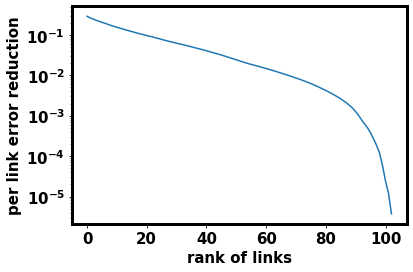

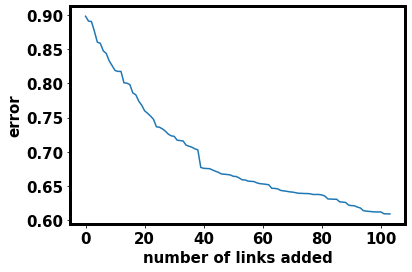

In [237]:
plt.figure()
plt.plot(np.cumsum(np.sort(df_added_tables['error reduced'].values))[::-1])
plt.yscale('log')
plt.ylabel('per link error reduction')
plt.xlabel('rank of links')

plt.figure()
plt.plot(error_list)
plt.ylabel('error')
plt.xlabel('number of links added')

In [238]:
df_MAMBO = pd.read_csv("mambo_curated.txt", sep = '\t')
df_MAMBO.head()

,microbe,metabolite,edge_type,microbe_Chia_name,microbe_ID,metabolite_Chia_name,metabolite_ID
0,"Bacteroides plebeius M12, DSM 17135","(S)-propane-1,2-diol",5,Bacteroides plebeius,131,"1,2-propanediol (Propene diol, Propylene glyco...",2004
1,"Bacteroides plebeius M12, DSM 17135",acetate,5,Bacteroides plebeius,131,Acetate,2014
2,"Bacteroides plebeius M12, DSM 17135",Adenosine,5,Bacteroides plebeius,131,Adenosine,2018
3,"Bacteroides plebeius M12, DSM 17135",Adenosylcobalamin,5,Bacteroides plebeius,131,"Adenosylcobalamin (Vitamin B12, Cobamide coenz...",2019
4,"Bacteroides plebeius M12, DSM 17135",L-arabinose,5,Bacteroides plebeius,131,"D-Arabinose (L-Arabinose, Arabinose, L-Arabino...",2060


In [239]:
chia_microbes_in_Thai = df_microbes.reset_index().set_index('newID').loc[thai_metagenome_ID].values.flatten()
chia_metabolites_in_Thai = df_metabolites.reset_index().set_index('newID').loc[thai_metabolome_ID].values.flatten()
#chia_microbes_in_Thai
#chia_microbes_in_Thai

df_MAMBO_filtered = df_MAMBO[df_MAMBO['microbe_ID'].apply(lambda x: x in chia_microbes_in_Thai)]
df_MAMBO_filtered = df_MAMBO_filtered[df_MAMBO_filtered['metabolite_ID'].apply(lambda x: x in chia_metabolites_in_Thai)]
print(len(df_MAMBO_filtered), x.shape[0])
print(len(df_MAMBO_filtered) / x.shape[0])

2162 11664
0.18535665294924555


In [240]:
k = 0
l = 0
for i in range(NUMADDED):
    if (np.sum((df_MAMBO['microbe_ID'] == df_added_tables['microbes ID'].iloc[i])) >=1 and 
       np.sum((df_MAMBO['metabolite_ID'] == df_added_tables['metabolite ID'].iloc[i]))>=1):
        l += 1
    if np.sum((df_MAMBO['microbe_ID'] == df_added_tables['microbes ID'].iloc[i]) & 
       (df_MAMBO['metabolite_ID'] == df_added_tables['metabolite ID'].iloc[i]))>=1:
        k += 1
print(l)
print(k)

76
44


3.868775411142167e-09

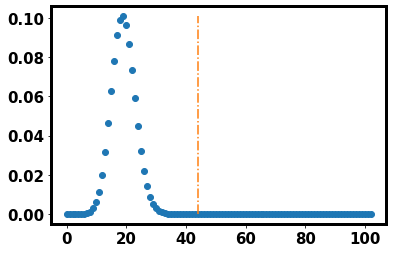

In [241]:
from scipy.stats import bernoulli, binom
xx = range(NUMADDED)
p = len(df_MAMBO_filtered) / x.shape[0]
#prob = bernoulli.cdf(xx, p)
probCum = binom.cdf(xx, NUMADDED, p)
prob = binom.pmf(xx, NUMADDED, p)
plt.plot(xx, prob, 'o')
plt.plot([k, k], [0, np.max(prob)], '-.')
1 - probCum[k]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.6259721822119966
            Iterations: 9
            Function evaluations: 204
            Gradient evaluations: 9
     fun: 2.6259721822119966
     jac: array([ 0.00000000e+00,  4.26459312e-03,  1.23884887e-01,  4.06563282e-04,
        4.77891296e-01,  2.13326514e-02,  4.77891296e-01,  2.77922899e-01,
       -9.78895426e-02,  5.91114163e-03,  4.55306590e-01,  1.26545429e-01,
        1.07567757e-01,  5.59255481e-03,  3.32587957e-03,  1.22976661e-01,
        4.67244297e-01,  3.81114155e-01,  7.48643279e-03,  6.84148073e-03])
 message: 'Optimization terminated successfully.'
    nfev: 204
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([5.00000000e-02, 1.22964499e+00, 1.95823587e-13, 5.30153886e-02,
       1.97124694e-13, 7.30368251e-01, 1.89723757e-13, 1.55728676e-13,
       0.00000000e+00, 1.19617622e+00, 1.85047313e-13, 1.98309264e-13,
       1.82848855e-13, 1.19477075e+00

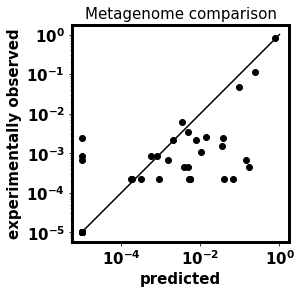

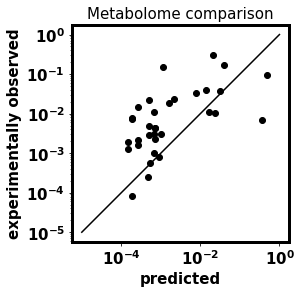

In [226]:
################################# Predict metabolome from individual's metagenome.

f_byproduct = 0.9
f = f_byproduct * np.ones((MAX_ID_microbes,1));
f[i_selfish] = 0.0;  # The byproduct/leakage fraction f for microbes that don't generate byproducts is set as 0.

numLevels_max = 4

######## Select an ID of a individual and pull out its experimentally measured metagenome:
pa = 1; 
b_real = np.zeros((MAX_ID_microbes,))
b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

######## Compute matrices involving the metabolite consumption and generation:
m2b, b2m = Ain_out(b_real, net_new)
m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
#m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(i_nonzero_microbes, i_nonzero_metabolites, f, m2b, b2m, numLevels_max)

######## Assign diet
x0 = np.ones((len(i_intake),)) / len(i_intake)

######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
# minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
# from the model for a certain nutrient intake.
fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
bnds = ((0, 100), ) * len(x0)
res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'disp': True, 'maxiter': 1000}, tol=1e-3)
#res = minimize(fun, x0, method='Nelder-Mead', bounds=bnds, options={'disp': True})
#res = minimize(fun, x0, method='TNC', bounds=bnds, options={'disp': True, 'maxiter': 1000})
print(res)

######## As long as the optimized nutrient intake is found by using the above optimization solver, the
# optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
# visually and statistically compared to the experimentally measured metagenome and metabolome.
x_full = np.zeros((MAX_ID_metabolites,));
x_full[i_intake] = res.x;
ba_pred = np.dot(m2b_total, x_full)

#### Metagenome comparison
fig, ax = plt.subplots()
ax.loglog(ba_pred+1e-5, b_real+1e-5, 'ko')
ax.plot([1e-5, 1], [1e-5, 1],'k-')
ax.set_aspect('equal')
ax.set_xlabel('predicted')
ax.set_ylabel('experimentally observed')
ax.set_title('Metagenome comparison')

met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
metabolome_measured = np.zeros((MAX_ID_metabolites,))
#metabolome_measured[thai_metabolome_ID.values] = thai_metabolome.iloc[:,pa]
metabolome_measured[thai_metabolome_ID] = thai_metabolome.iloc[:,pa]
metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
#metabolome_pred = np.dot(m2m_total, x_full)
i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

#### Metabolome comparison
fig, ax = plt.subplots()
ax.loglog(metabolome_pred_common+1e-5, metabolome_measured_common+1e-5, 'ko')
ax.plot([1e-5, 1], [1e-5, 1],'k-')
ax.set_aspect('equal')
ax.set_xlabel('predicted')
ax.set_ylabel('experimentally observed')
ax.set_title('Metabolome comparison')

print('-------------------------------------------------------------------------------------------------------------')
print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
print(pearsonr(metabolome_pred_common, metabolome_measured_common))

In [211]:
from scipy.stats import pearsonr, spearmanr
print(pearsonr(metabolome_pred_common, metabolome_measured_common))
print(spearmanr(metabolome_pred_common, metabolome_measured_common))
print(pearsonr(np.log10(metabolome_pred_common+1e-5), np.log10(metabolome_measured_common+1e-5)))

(0.16515233534383644, 0.35836996444599467)
SpearmanrResult(correlation=0.6367903339818396, pvalue=6.768421527804663e-05)
(0.6077239873632551, 0.00017610255821343742)


In [21]:
#i_x
max_links*2












11664

## Add a prior distribution for picking links

In [ ]:
max_links = thai_metabolome_ID.shape[0]*thai_metagenome_ID.shape[0]
    
######## Convert x to net structure:
thres = 0.1
x = x - x_ori
m2b_added = x[:max_links].reshape((thai_metabolome_ID.shape[0], thai_metagenome_ID.shape[0]))


numpy.random.choice(numpy.arange(0, max_links*2), p=[0.1, 0.05, 0.05, 0.2, 0.4, 0.2])